In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Save Kyoto_Gases data (2020-2100), consider the case of C1-C8 for simplicity.
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')
X_Emissions = Kyoto_Gases
X_Emissions = X_Emissions[X_Emissions['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
X_Emissions.reset_index(drop=True,inplace=True)
mapping = {'C1':1,'C2':2,'C3':3,'C4':4,'C5':5,'C6':6,'C7':7,'C8':8}
X_Emissions['Category'].replace(mapping,inplace=True)
X_Emissions.drop(columns=['Category_name'],inplace=True)

C:\Users\l1137\AppData\Local\Temp\ipykernel_15440\3013020388.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Emissions['Category'].replace(mapping,inplace=True)
C:\Users\l1137\AppData\Local\Temp\ipykernel_15440\3013020388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Emissions.drop(columns=['Category_name'],inplace=True)


In [3]:
#Merge models according to a uniform standard
MESSAGEix = list(set([i for i in X_Emissions['Model'] if  'MESSAGE' in i]))
WITCH = list(set([i for i in X_Emissions['Model'] if  'WITCH' in i]))
COFFEE = ['COFFEE 1.1']
REMIND = list(set([i for i in X_Emissions['Model'] if  'REM' in i]))
TIA = list(set([i for i in X_Emissions['Model'] if  'TIAM-ECN' in i]))
POL = list(set([i for i in X_Emissions['Model'] if  'POL' in i]))
AIM = list(set([i for i in X_Emissions['Model'] if  'AIM' in i]))
IMA = list(set([i for i in X_Emissions['Model'] if  'IMAGE' in i]))
GCA = list(set([i for i in X_Emissions['Model'] if  'GCA' in i]))

In [4]:
Model = [MESSAGEix,WITCH,COFFEE,REMIND,TIA,POL,AIM,IMA,GCA]
Model_names = ['MESSAGEix','WITCH','COFFEE','REMIND','TIA','POL','AIM','IMA','GCA']
Model_List = []
for i in Model:
    Model_List += i

In [5]:
X_Emissions = X_Emissions[X_Emissions['Model'].isin(Model_List)]

In [6]:
mapping = {j:Model_names[i] for i in range(len(Model)) for j in Model[i]}
X_Emissions['Model'].replace(mapping,inplace=True)
X_Emissions.reset_index(drop=True,inplace=True)

In [7]:
#Load a dataset of individual variables
CarbonSequestration = pd.read_csv('Carbon_Sequestration_CCS_imputed.csv')
FinalEnergy_Gase = pd.read_csv('Final Energy_Gases.csv')
FinalEnergy_Liquid = pd.read_csv('Final Energy_Liquids.csv')
FinalEnergy_Solid = pd.read_csv('Final Energy_Solids.csv')
FinalEnergy = pd.read_csv('Final_Energy_ts_imputed.csv')
PrimaryEnergy_Gas = pd.read_csv('Primary Energy_Gas.csv')
PrimaryEnergy_Oil = pd.read_csv('Primary Energy_Oil.csv')
PrimaryEnergy_Solar = pd.read_csv('Primary Energy_Solar.csv')
PrimaryEnergy_Coal = pd.read_csv('PrimaryEnergy_Coal.csv')
PrimaryEnergy = pd.read_csv('PrimaryEnergy_imputed.csv')
SecondaryEnergy_Gas = pd.read_csv('Secondary Energy_Gases.csv')
SecondaryEnergy_Liquid = pd.read_csv('Secondary Energy_Liquids.csv')
SecondaryEnergy_Electricity = pd.read_csv('SecondaryEnergyElectricity_imputed.csv')

In [8]:
#Get the intersection of the models and scenarios contained in each variable
baseline = X_Emissions[['Model','Scenario']]
Variables = [CarbonSequestration,FinalEnergy,FinalEnergy_Gase,FinalEnergy_Liquid,FinalEnergy_Solid,PrimaryEnergy,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil,PrimaryEnergy_Solar,SecondaryEnergy_Electricity,SecondaryEnergy_Gas,SecondaryEnergy_Liquid]
for i in range(len(Variables)):
    Variables[i]['Model'].replace(mapping,inplace=True)
for variable in Variables:
    baseline = pd.merge(baseline,variable[['Model','Scenario']],on=['Model','Scenario'],how='inner')

In [9]:
for i in range(len(Variables)):
     Variables[i] = pd.merge(baseline,Variables[i],on=['Model','Scenario'],how='inner')

In [10]:
Features = np.zeros((996,13))#Features:13 Features Accumulation from 2010 to 2100
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        for k in range(9):
            Features[i][j] += (X[i][k] + X[i][k+1]) * 5

In [11]:
X_Emissions = pd.merge(X_Emissions,baseline,on = ['Model','Scenario'],how = 'inner')

In [12]:
columns_names = ['CarbonSequestration','FinalEnergy','FinalEnergy_Gase','FinalEnergy_Liquid','FinalEnergy_Solid','PrimaryEnergy','PrimaryEnergy_Coal','PrimaryEnergy_Gas','PrimaryEnergy_Oil','PrimaryEnergy_Solar','SecondaryEnergy_Electricity','SecondaryEnergy_Gas','SecondaryEnergy_Liquid']
DataSet = pd.DataFrame(Features,columns = columns_names)
DataSet['Category'] = X_Emissions['Category']

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
X = DataSet.drop(columns='Category')
y = DataSet['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Create random forest classifier object
classifier = RandomForestClassifier(random_state=5)
parameters_1 = {
    'n_estimators':[10,100,500,1000,3000],
    'max_depth':[6,8,10,12,14],
    'min_samples_split':[4,6,8]
}

# GridSearch and Fitting model
gridsearch = GridSearchCV(classifier,parameters_1,cv=3,n_jobs=-1,verbose=2)
gridsearch.fit(X_train,y_train)
print(f"Best Params Founded:{gridsearch.best_params_}")

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best Params Founded:{'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 100}


In [14]:
# Fitting model
rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=12,min_samples_split=4,random_state=5)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Classification accuracy on training datasets:", accuracy)

Classification accuracy on training datasets: 0.9886934673366834


In [15]:
# Prediction on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Classification accuracy on test datasets:", accuracy)

Classification accuracy on test datasets: 0.835


In [16]:
#Importance of Feature
importance = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df)
#The importance score of each feature is ranked from largest to smallest

                        Feature  Importance
6            PrimaryEnergy_Coal    0.153810
0           CarbonSequestration    0.134244
8             PrimaryEnergy_Oil    0.100030
7             PrimaryEnergy_Gas    0.082966
3            FinalEnergy_Liquid    0.079368
5                 PrimaryEnergy    0.069911
11          SecondaryEnergy_Gas    0.061578
4             FinalEnergy_Solid    0.060628
2              FinalEnergy_Gase    0.053313
12       SecondaryEnergy_Liquid    0.053295
10  SecondaryEnergy_Electricity    0.053052
1                   FinalEnergy    0.051673
9           PrimaryEnergy_Solar    0.046132


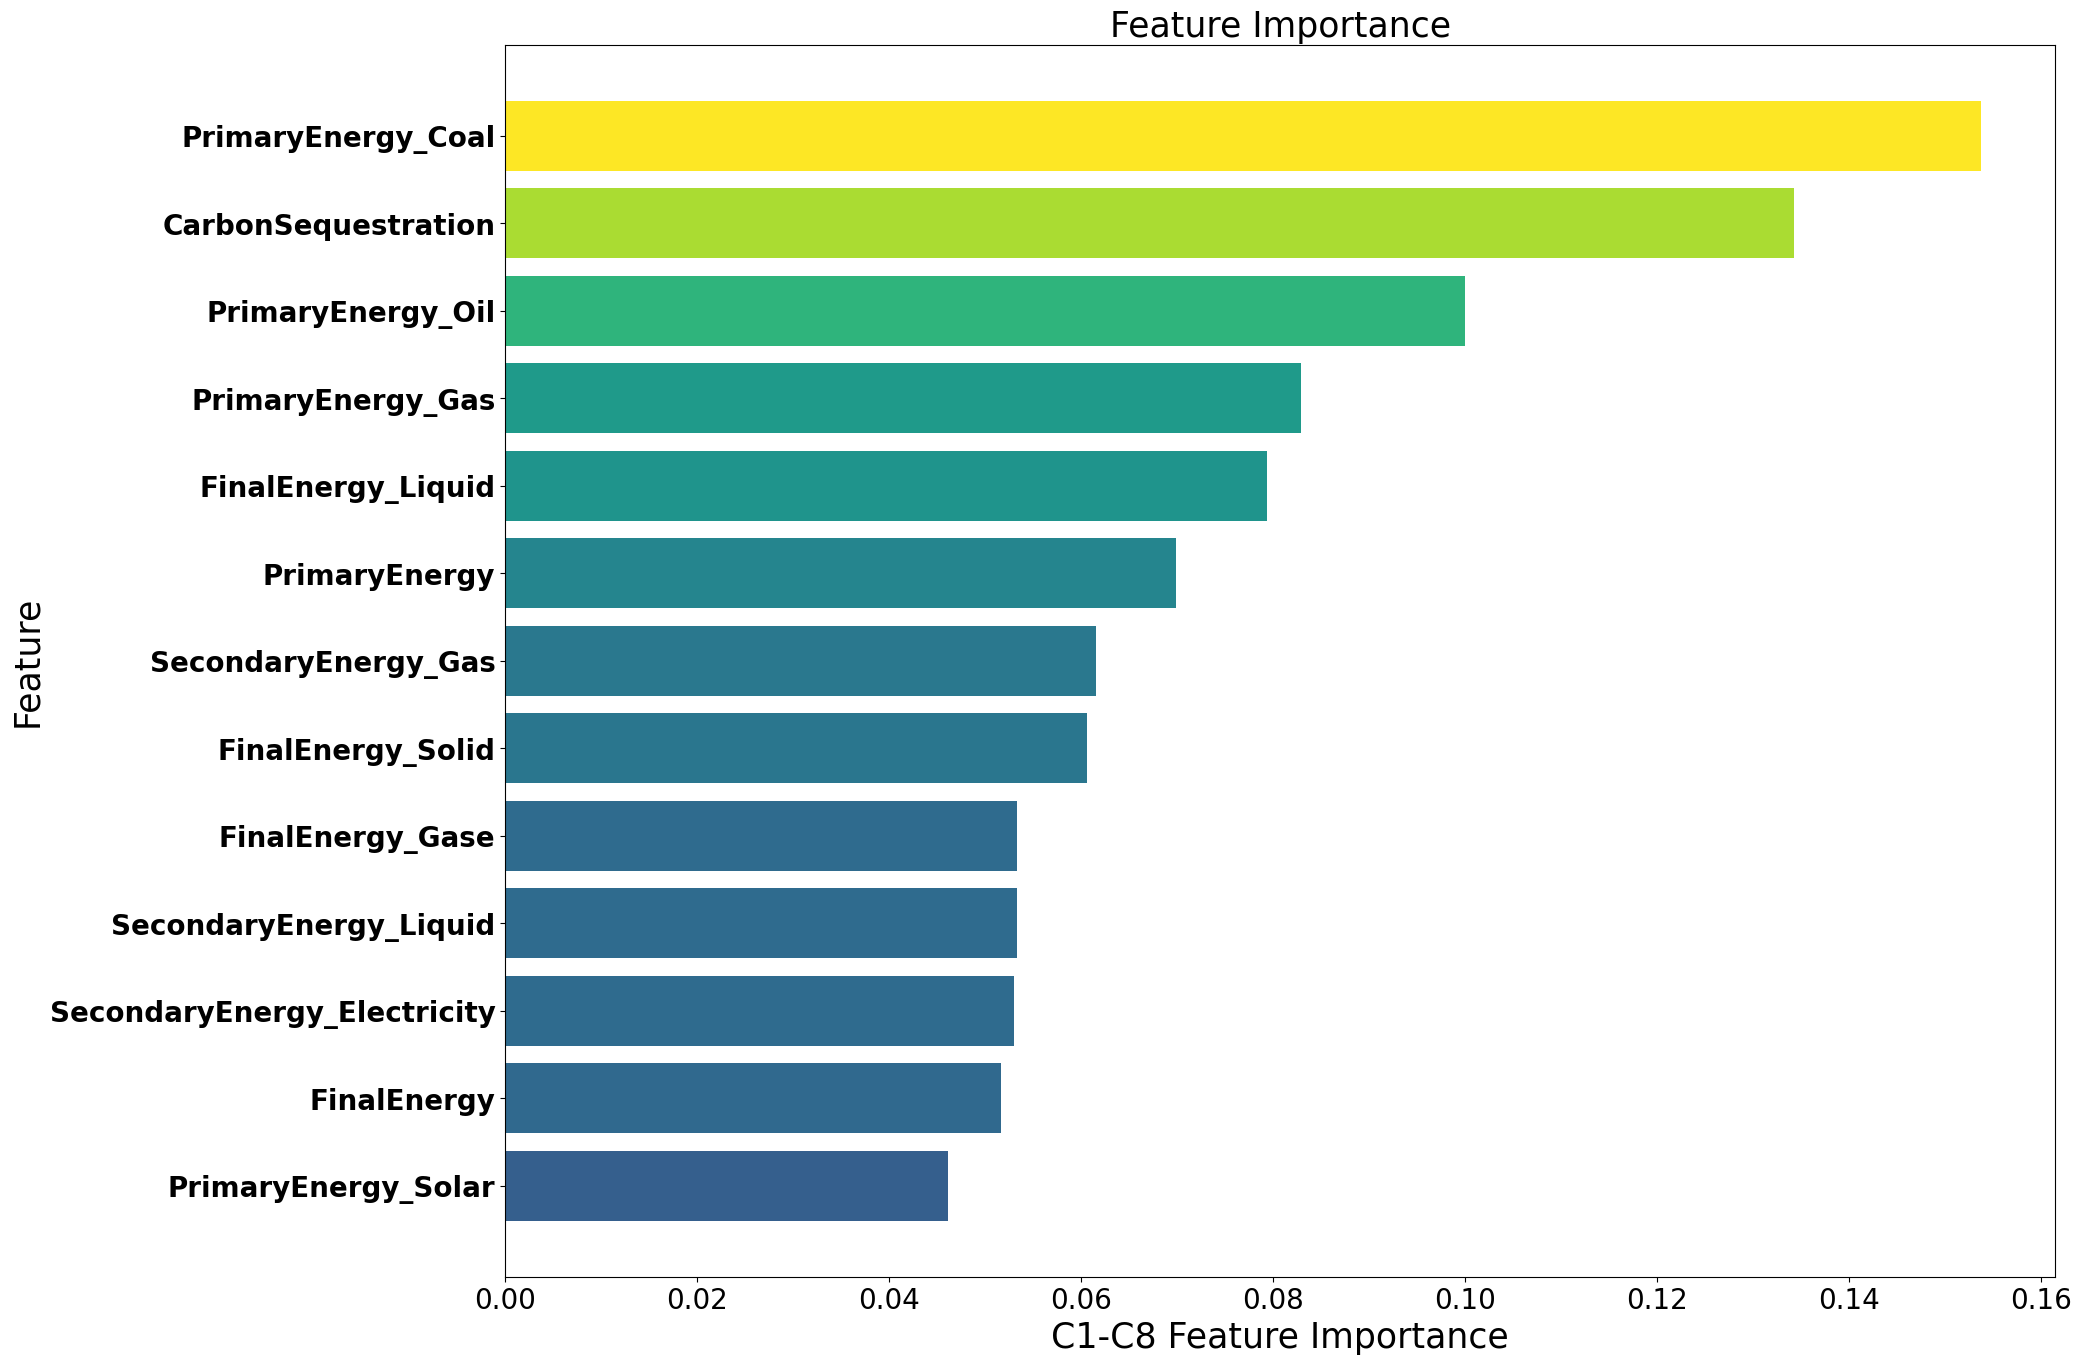

In [17]:
plt.figure(figsize=(20, 16))
sorted_df = feature_importance_df.sort_values(by='Importance', ascending=True)
colors = plt.cm.viridis(sorted_df['Importance'] / np.max(sorted_df['Importance']))
plt.barh(sorted_df['Feature'], sorted_df['Importance'],color = colors)
plt.xlabel('C1-C8 Feature Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)
plt.title('Feature Importance',fontsize=25)
plt.yticks(fontsize=20,weight='bold')
plt.xticks(fontsize=20)
plt.savefig('S2 C1-C8-Category-Feature .pdf',format='pdf',bbox_inches='tight')
plt.show()

In [18]:
#Aggregate the categories and then train the random forest model
mapping = {1:1,2:1,3:1,4:1,5:2,6:2,7:3,8:3}# Agg-Category C1234,C56,C78
DataSet['Category'].replace(mapping,inplace=True)

In [19]:
X = DataSet.drop(columns='Category')
y = DataSet['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

#Create random forest classifier object
classifier2 = RandomForestClassifier(random_state=8)
parameters_2 = {
    'n_estimators':[10,100,500,1000,3000],
    'max_depth':[6,8,10,12,14],
    'min_samples_split':[4,6,8]
}

# GridSearch and Fitting model
gridsearch = GridSearchCV(classifier2,parameters_2,cv=5,n_jobs=-1,verbose=2)
gridsearch.fit(X_train,y_train)
print(f"Best Params Founded:{gridsearch.best_params_}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Params Founded:{'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 100}


In [20]:
# Fitting Model
rf_classifier2 = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,random_state=8)
rf_classifier2.fit(X_train, y_train)
y_pred = rf_classifier2.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Classification accuracy on training datasets:", accuracy)

Classification accuracy on training datasets: 0.9974874371859297


In [21]:
# Predict on test data
y_pred = rf_classifier2.predict(X_test)

# Calculate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print("classification accuracy:", accuracy)

classification accuracy: 0.97


In [22]:
#Feature Importance
importance = rf_classifier2.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df)
#The importance score of each feature is ranked from largest to smallest

                        Feature  Importance
6            PrimaryEnergy_Coal    0.193026
0           CarbonSequestration    0.189802
7             PrimaryEnergy_Gas    0.123442
8             PrimaryEnergy_Oil    0.111728
3            FinalEnergy_Liquid    0.070537
5                 PrimaryEnergy    0.067984
12       SecondaryEnergy_Liquid    0.042052
11          SecondaryEnergy_Gas    0.040360
2              FinalEnergy_Gase    0.037966
4             FinalEnergy_Solid    0.034746
1                   FinalEnergy    0.030384
10  SecondaryEnergy_Electricity    0.030054
9           PrimaryEnergy_Solar    0.027920


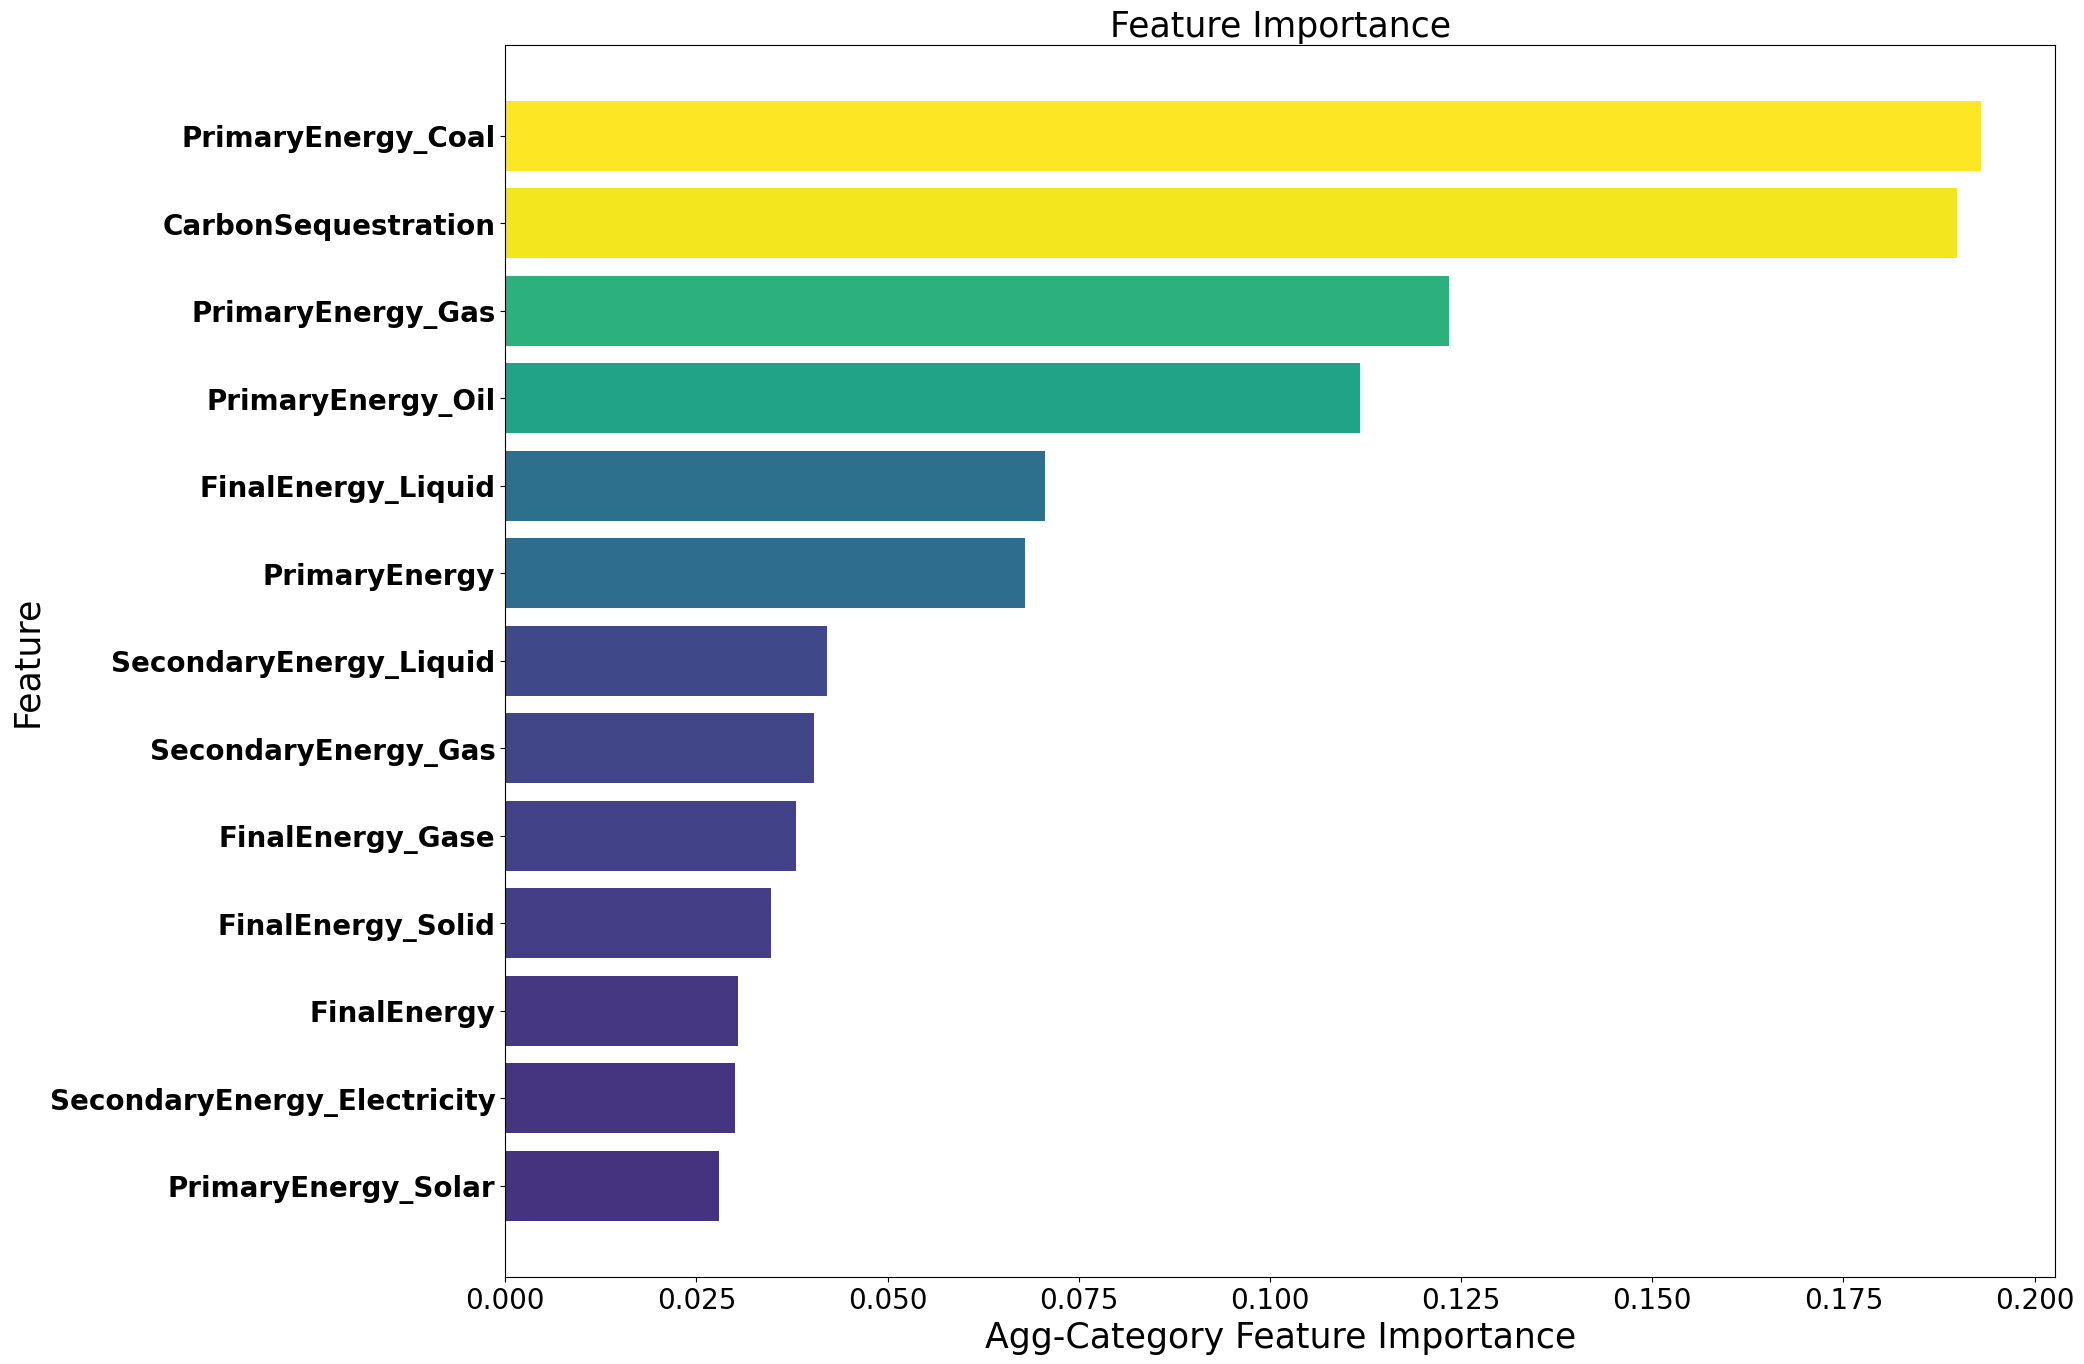

In [23]:
plt.figure(figsize=(20, 16))
sorted_df = feature_importance_df.sort_values(by='Importance', ascending=True)
colors = plt.cm.viridis(sorted_df['Importance'] / np.max(sorted_df['Importance']))
plt.barh(sorted_df['Feature'], sorted_df['Importance'],color = colors)
plt.xlabel('Agg-Category Feature Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)
plt.title('Feature Importance',fontsize=25)
plt.yticks(fontsize=20,weight='bold')
plt.xticks(fontsize=20)
plt.savefig('S2 Agg-Category Feature .pdf',format='pdf',bbox_inches='tight')
plt.show()